In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core_update')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core_update import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (300,300,300),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=30, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)

pos = 0.7

test_phantom.add_tissue_sphere((pos,-pos,0), 8, blood)
test_phantom.add_tissue_sphere((pos,0,0), 16, blood)
test_phantom.add_tissue_sphere((pos,pos,0), 32, blood)

test_phantom.add_tissue_sphere((-pos,-pos,0), 16, fat)
test_phantom.add_tissue_sphere((-pos,0,0), 32, fat)
test_phantom.add_tissue_sphere((-pos,pos,0), 8, fat)

test_phantom.add_tissue_sphere((0,-pos,0), 32, myocardium)
test_phantom.add_tissue_sphere((0,0,0), 8, myocardium)
test_phantom.add_tissue_sphere((0,pos,0), 16, myocardium)

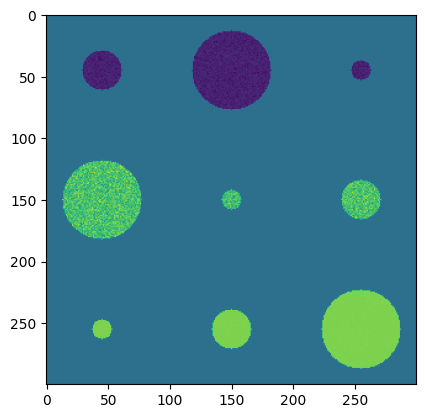

In [3]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [34]:
transducers = [transducer.Planewave(elements = 32, 
                       width = 20e-3,
                       height =  20e-3,
                       sensor_sampling_scheme = 'not_centroid', 
                       sweep = np.pi/3,
                       ray_num = 32, 
                       imaging_ndims = 2,
                       focus_elevation = 20e-3,
                       ) for i in range(2)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

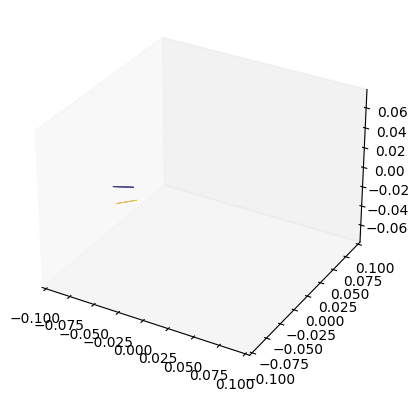

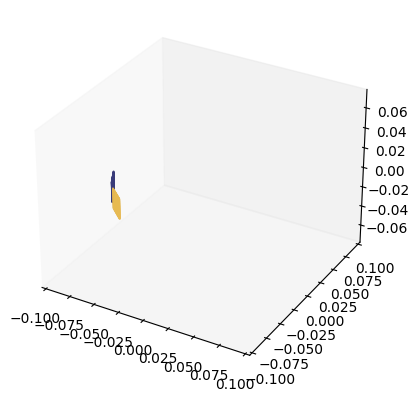

In [35]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 80e-3, 'view_std': 0, 'yaw_fraction': 0.3, 'pitch_fraction': 0, 'roll_fraction': 0})
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [36]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='fdasfjk')

In [37]:
simprops = simulation.SimProperties(
                grid_size   = (160e-3,30e-3,30e-3),
                voxel_size  = (0.1e-3,0.1e-3,0.1e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [38]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/update_pw_01',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 )

test_experiment.save()

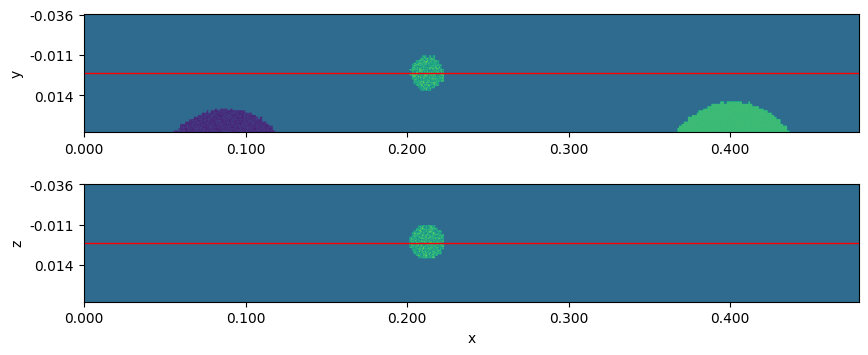

In [39]:
test_experiment.plot_ray_path(16)

In [40]:
test_experiment = experiment.Experiment.load('../experiment_files/update_pw_01')
test_experiment.run(dry=True)

Number of simulation results (0) is less than the expected number of simulation results (64), are you sure the simulation finished running?
dry run of simulation


  0%|          | 0/2 [00:00<?, ?it/s]

0.0
0.0
0.0


 50%|█████     | 1/2 [00:24<00:24, 24.33s/it]

0.0
0.0


100%|██████████| 2/2 [00:28<00:00, 14.13s/it]

0.0


In [41]:
test_experiment.run()

running with 3 workers

783.0
preparation for sim   32 completed in           16.94 seconds
432.0
preparation for sim    0 completed in           32.92 seconds
783.0
preparation for sim   33 completed in           82.10 seconds
432.0
preparation for sim    1 completed in           84.32 seconds


In [12]:
test_experiment.add_results()

In [13]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [14]:
# test_reconstruction.plot_ray_path(0)

In [15]:
test_reconstruction.plot_scatter()

IndexError: list index out of range

In [ ]:
image, signals = test_reconstruction.get_image(dimensions=2, downsample = 1, workers=1)

multiproc time 1.4765233993530273


100%|██████████| 8/8 [00:48<00:00,  6.10s/it]


[]

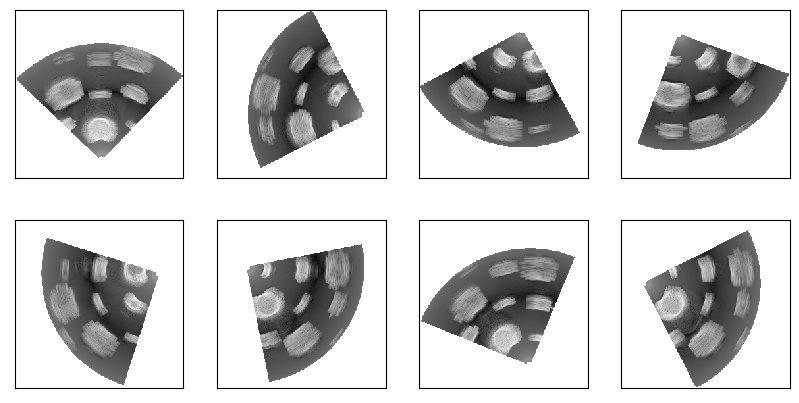

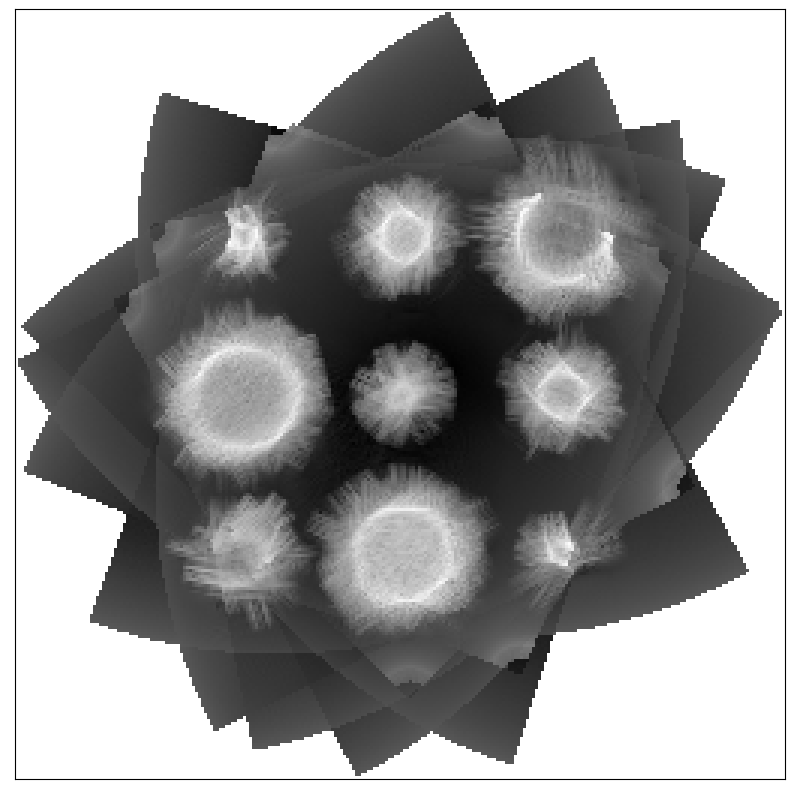

In [ ]:
X = np.linspace(-1, 1, 256)
Y = np.linspace(-1, 1, 256)
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(2,4, figsize=(10,5))
ax[0,0].pcolormesh(X, Y, signals[0], shading='auto', cmap='gray', norm='log')
ax[0,1].pcolormesh(X, Y, signals[1], shading='auto', cmap='gray', norm='log')
ax[0,2].pcolormesh(X, Y, signals[2], shading='auto', cmap='gray', norm='log')
ax[0,3].pcolormesh(X, Y, signals[3], shading='auto', cmap='gray', norm='log')
ax[1,0].pcolormesh(X, Y, signals[4], shading='auto', cmap='gray', norm='log')
ax[1,1].pcolormesh(X, Y, signals[5], shading='auto', cmap='gray', norm='log')
ax[1,2].pcolormesh(X, Y, signals[6], shading='auto', cmap='gray', norm='log')
ax[1,3].pcolormesh(X, Y, signals[7], shading='auto', cmap='gray', norm='log')

for axd1 in ax:
    for a in axd1:
        a.set_aspect('equal')
        a.set_xticks([])
        a.set_yticks([])

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.pcolormesh(X, Y, image, shading='auto', cmap='gray', norm='log')
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

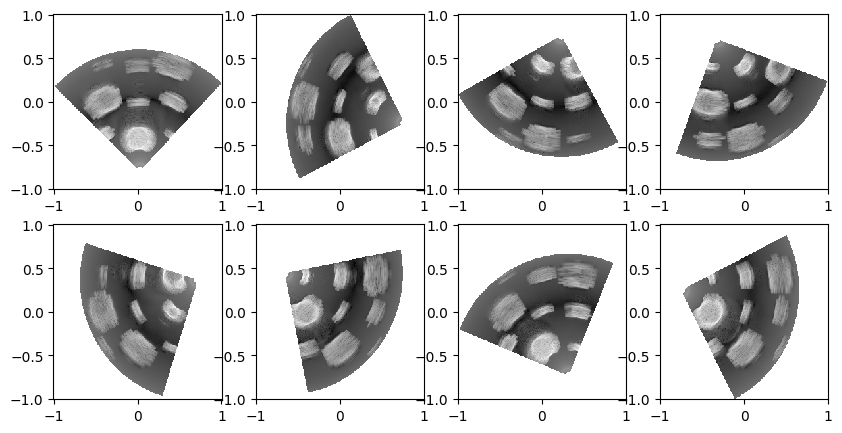

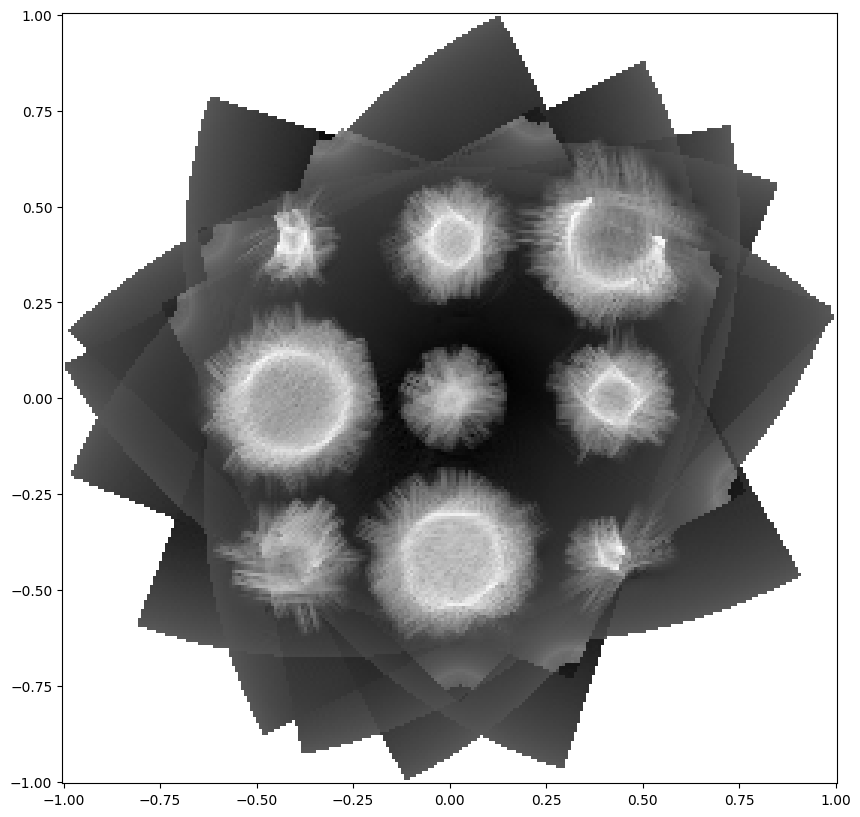

In [ ]:
X = np.linspace(-1, 1, 256)
Y = np.linspace(-1, 1, 256)
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(2,4, figsize=(10,5))
ax[0,0].pcolormesh(X, Y, signals[0], shading='auto', cmap='gray', norm='log')
ax[0,1].pcolormesh(X, Y, signals[1], shading='auto', cmap='gray', norm='log')
ax[0,2].pcolormesh(X, Y, signals[2], shading='auto', cmap='gray', norm='log')
ax[0,3].pcolormesh(X, Y, signals[3], shading='auto', cmap='gray', norm='log')
ax[1,0].pcolormesh(X, Y, signals[4], shading='auto', cmap='gray', norm='log')
ax[1,1].pcolormesh(X, Y, signals[5], shading='auto', cmap='gray', norm='log')
ax[1,2].pcolormesh(X, Y, signals[6], shading='auto', cmap='gray', norm='log')
ax[1,3].pcolormesh(X, Y, signals[7], shading='auto', cmap='gray', norm='log')

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.pcolormesh(X, Y, image, shading='auto', cmap='gray', norm='log')

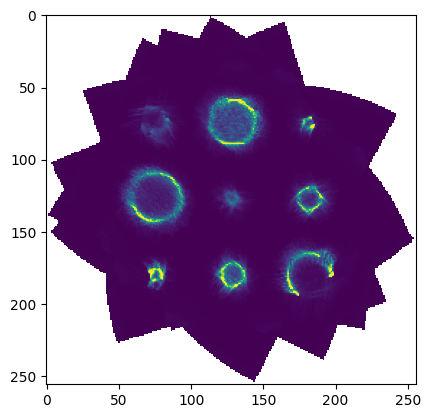

In [ ]:
plt.imshow(image, vmax=10000)

/tmp/ipykernel_602626/4135272851.py:3: RuntimeWarning: invalid value encountered in log
  ax.pcolor(np.log(image_rays + 2))


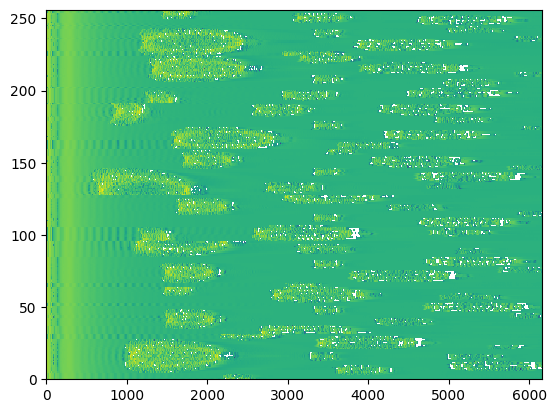

In [ ]:
fig, ax = plt.subplots(1, 1)
image_rays = np.stack([np.mean(test_experiment.results[i][1], axis=0)[100:] for i in range(len(test_experiment.results))])
ax.pcolor(np.log(image_rays + 2))